In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20) 
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1673
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6345e-04
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1560e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9493e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8260e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7456e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6377e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5280e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4041e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4379e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4286e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4821e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5013e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4747e-04
Epoch 15/100
57/57 

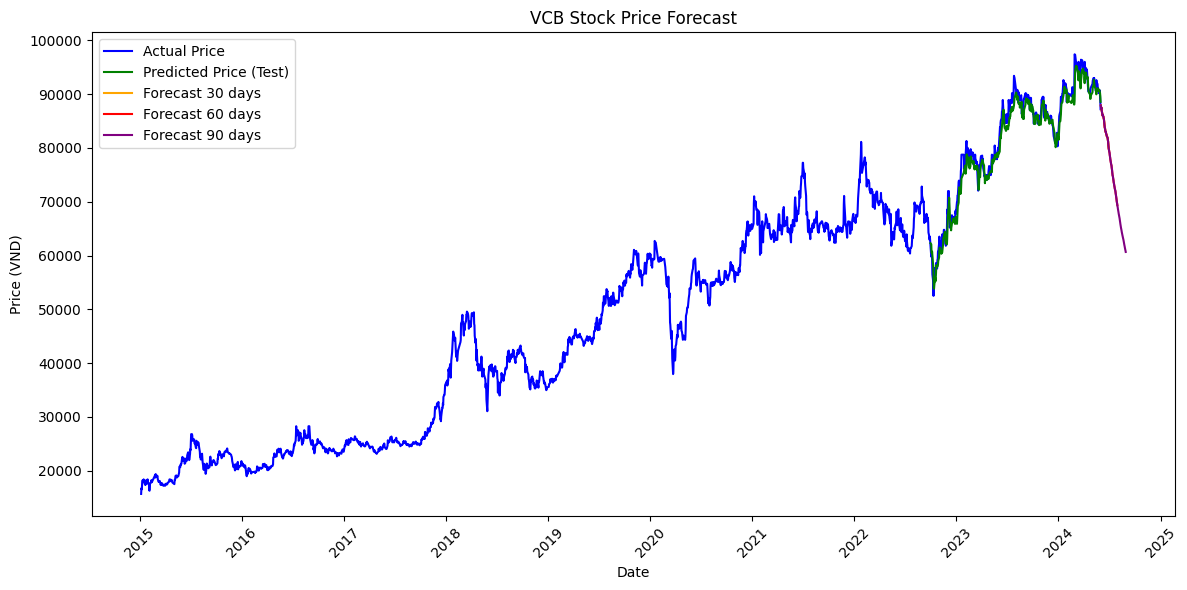

In [5]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('VCB Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  87870.890625
2024-06-02  87320.710938
2024-06-03  87507.984375
2024-06-04  86938.367188
2024-06-05  86643.023438
...                  ...
2024-08-25  61725.777344
2024-08-26  61432.453125
2024-08-27  61174.843750
2024-08-28  60930.988281
2024-08-29  60663.972656

[90 rows x 1 columns]
